# Problema 48
Integraremos un N-Body, utilizando el método **LF-KDK** con un paso de $h = 0.1$ durante $t=1000$ para una distribución de $N=100$ pts que siguen el perfil de densidad radial $n(r) \sim cte$, con velocidades iniciales $\vec v_i = 0$, en una esfera de radio $R=150$. <br>
Supondremos $G=1$, $m_i = m = 1$  $\forall i \in (1,...,N)$.

In [47]:
using Plots
using Random
using LinearAlgebra
using Statistics

function distrib(n=100,L=300,s=1) #n = cant de partículas
                               #L = size del box 3D
                               #s = seed a elegir (para cambiar if I wanna)
    
    Random.seed!(s) #pickeo seed
    
    pos = rand(n,3) #randoms uniformes entre 0 y 1. De acá saco theta, phi y r y llevo a coord esféricas:
    
    r = (pos[:,1].^(1/3)).*L #Extiendo hasta L, y busco que sea radial unif
    theta = acos.(2 .*pos[:,2] .- 1) #theta va entre -pi y pi
    phi = (2*pi).*pos[:,3] #phi va entre 0 y 2pi
    
    x = r.*sin.(theta).*cos.(phi)
    y = r.*sin.(theta).*sin.(phi)
    z = r.*cos.(theta)
    
    plt = scatter(x,y, xlabel="x", ylabel="y", title = "Distribución inicial de $n pts en una esfera de radio $L \n Plano (x,y)",
                 label="m = 1",  ms=3,color="yellow", grid = true,size=(800,800),
                 xlim=(-400,400),ylim=(-400,400)) #ploteo
    
    x_cm = mean(x)
    y_cm = mean(y)
    z_cm = mean(z)
    
    plt = scatter!([x_cm],[y_cm],color="black",seriestype = :scatter,label="CM", legend=true,  ms=5, shape=:cross)
    
    display(plt)
    
    #Energía:
    
    E = 0.
    
    for i in 1:n
        for j in 1:n
            if i == j
                continue
            else
                d = norm((x[i]-x[j],y[i]-y[j],z[i]-z[j]))
                E += -1/d
            end        
        end
        
    end
    
    return x,y,z,E
end

distrib (generic function with 4 methods)

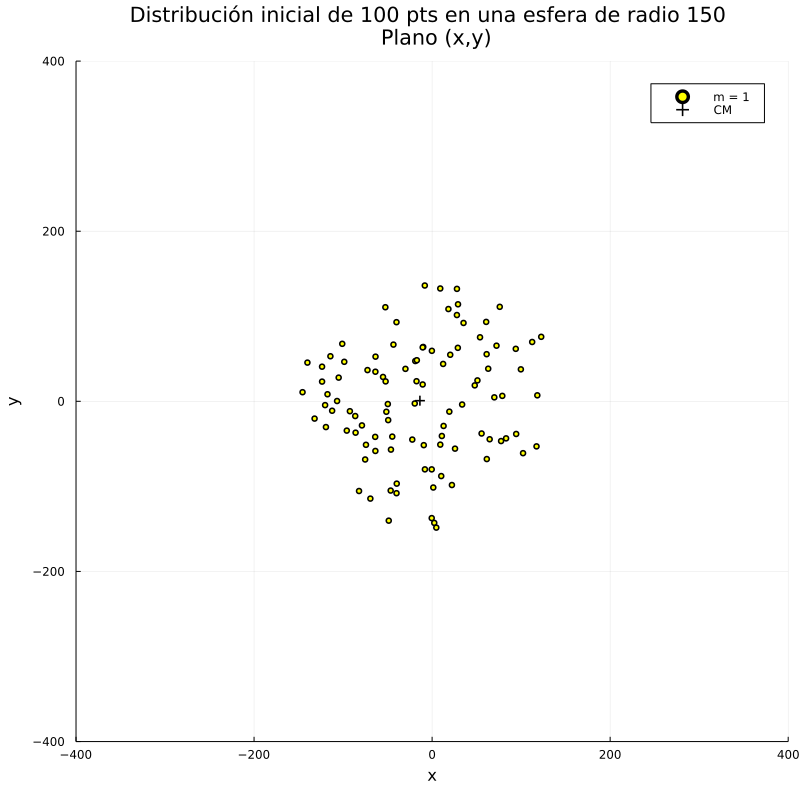

  0.896931 seconds (3.04 M allocations: 161.186 MiB, 7.88% gc time, 95.06% compilation time)


In [48]:
@time x,y,z,E0 = distrib(100,150,0);

In [37]:
#Aceleración:

function a(x=x,y=y,z=z,e=0.5,n=size(x)[1])  #aceleración de cada partícula debido al resto (sup G = 1)
                                            #e = softening; n = cant de part, debe ser = al n de distrib
        
    ax = zeros(n)
    ay = zeros(n)
    az = zeros(n)
    
    for i in 1:n
        
        Sx = 0 #Var para sum. Para c/ part debo ver cómo le afectan las demás
        Sy = 0 #Direcc ortog => lo puedo cal por separado
        Sz = 0 
        
        for j in 1:n
            if i == j
                continue
            else
                r = norm((x[i]-x[j],y[i]-y[j],z[i]-z[j])) #módulo del vector dif entre particulas i y j
                Sx += (r^2 + e^2)^-1.5 * (x[i]-x[j])
                Sy += (r^2 + e^2)^-1.5 * (y[i]-y[j])
                Sz += (r^2 + e^2)^-1.5 * (z[i]-z[j])
                
            end
    
        ax[i] = -Sx
        ay[i] = -Sy
        az[i] = -Sz
                
        end 
                
    end
        
    return ax,ay,az #a = un array de n listas (= cant de aprticulas), con las aceleraciones en x y en y de cada espacio
                
end

a (generic function with 6 methods)

In [49]:
function LF(a=a,x=x,y=y,z=z,h=0.1,t=1000,N=size(x)[1])
            #(x,y) listas vacías excepto por las pos inic, (vx,vy) variables, pero comenzamos con las v inic.
            # a = (ax,ay) func para obtener la aceleración; n = cant de pasos; t = tiempo de integ
            # N = cant de part = n anteriores    
    kx = zeros(N)
    ky = zeros(N)
    kz = zeros(N)
    vx = zeros(N)
    vy = zeros(N) #v inic = 0, estos se van a ir sobreescribiendo
    vz = zeros(N)
    
    n = Int64(t/h)
    dE = zeros(n) #Delta E para c/ step
    
    for m in 1:n #pasos a realizar
        
        E = 0.
        
        for i in 1:N #cant de partículas
        
            kx[i] = vx[i] + a(x,y,z)[1][i]*h/2 #la func a se come las posiciones de todas las partículas, pero
                                             #siempre estoy viendo la particula i, y actualizo las pos y vel de cada part a la vez
                                             #antes de saltar al prox step m
            
            ky[i] = vy[i] + a(x,y,z)[2][i]*h/2
            kz[i] = vz[i] + a(x,y,z)[3][i]*h/2
            
        end
            
        for i in 1:N #Debo ir actualizando k, x y v de todas las part antes de pasar al prox parám (k -> x -> v) 

            x[i] = x[i] + kx[i]*h
            y[i] = y[i] + ky[i]*h
            z[i] = z[i] + kz[i]*h
            
            #println(x[1])
            
        end
            
        for i in 1:N

            vx[i] = kx[i] + a(x,y,z)[1][i]*h/2 #Esta a es con las pos de TODAS las part actualizadas (no sólo de 1, que es lo que
                                             # pasaría si estuvieran k, x y v en el mismo loop)
            vy[i] = ky[i] + a(x,y,z)[2][i]*h/2
            vz[i] = kz[i] + a(x,y,z)[3][i]*h/2
            
        end
        
        for i in 1:N
            for j in 1:N
                if i == j
                    continue
                else
                    d = norm((x[i]-x[j],y[i]-y[j],z[i]-z[j]))
                    E += -1/d
                end        
            end

            E += 0.5*(norm((vx[i],vy[i],vz[i])))^2
            
        end
        
        dE[m] = (E-E0)/E0
        
        #Y ahora si podemos pasar al prox step, guardando imags para la prox anim
        
        if mod(m,100) == 0

                plt = scatter(x,y, xlabel="x", ylabel="y", title = "N-body LF Problema 48): \n h = $h ; N = $N",
                           color="yellow",seriestype = :scatter, legend=false, ms=3, grid = true,
                           xlim = (-400,400), ylim = (-400,400),size=(800,800)) #ploteo
            
                x_cm = mean(x)
                y_cm = mean(y)
                z_cm = mean(z)
    
                plt = scatter!([x_cm],[y_cm],color="black",seriestype = :scatter,label="CM", legend=true,  ms=5, shape=:cross)
            
                #display(plt)
                savefig(plt,"P48_Nbody_$(m).png")
            
        end
     
    end
                        
    return x,y,z,dE #Para seguirlo si quiero desde donde lo dejó. Funcó

end

LF (generic function with 8 methods)

No corremos la integración, pero dejamos la animación correspondiente:

https://drive.google.com/file/d/1DD-Xqyv1jp1xLI3kRXYHXErVGR9eOiC2/view?usp=sharing

In [43]:
#x,y,z,dE = LF();

In [41]:
#Recordá que en cuanto se pare, se quedan guardados las x,y,z,dE => Puedo seguir evolucionandolo desde donde se quedo
#(Faltaría intercambiar m para no superponer los espacios de dE y de m de las pics) (!)
#O sea, agregar un "+4000" a m, porque dE ya lo guardé en el csv y lo puedo leer cuando quiera

#Pero no se guardan las velocidades... rip
#Pkg.add("DelimitedFiles")
using DelimitedFiles
using DataFrames
using CSV

#writedlm( "N-BodyP48_try2_1000.csv",  (x,y,z,dE), ',')
df = DataFrame(CSV.File("N-BodyP48_try2_1000.csv",header=false,delim=','))

dE_df = df[4,:]

┌ Warning: thread = 1 warning: parsed expected 100 columns, but didn't reach end of line around data row: 4. Parsing extra columns and widening final columnset
└ @ CSV C:\Users\Usuario\.julia\packages\CSV\cHirL\src\file.jl:579


,Column1,Column2,Column3,Column4,Column5,Column6,Column7
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
4,5.96739e-7,9.55049e-7,1.55225e-6,2.38835e-6,3.46339e-6,4.77741e-6,6.33045e-6


In [42]:
size(dE_df)

(10000,)

In [45]:
dE = zeros(size(dE_df)[1])
for i in 1:size(dE_df)[1]
   dE[i] = dE_df[i] 
end

Y dejamos el plot de $\Delta E(t)$ para el sistema

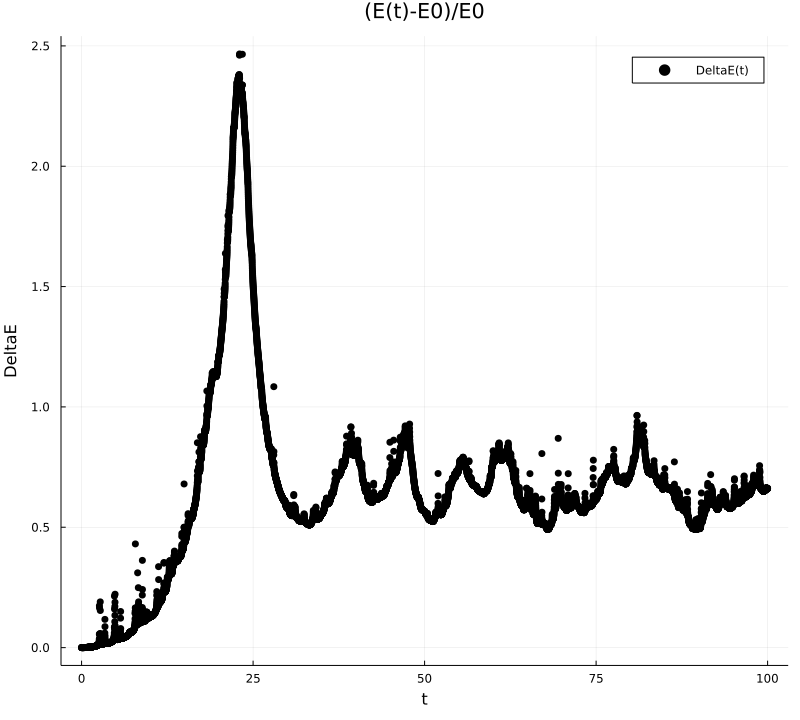

In [50]:
t = LinRange(0,100,10_000)
p = scatter(t,dE,title="(E(t)-E0)/E0",lw=3,color="black",label="DeltaE(t)",xlabel="t",ylabel="DeltaE",size=(800,720))
display(p)